In [1]:
import numpy as np
from pymoo.core.problem import ElementwiseProblem
from pymoo.algorithms.moo.ctaea import CTAEA
from pymoo.optimize import minimize
from pymoo.util.ref_dirs import get_reference_directions
from pymoo.visualization.scatter import Scatter

In [2]:
# Define the problem class
class EVChargingProblem(ElementwiseProblem):
    def __init__(self, n_pevgs=3, C=100, b_n=[35, 45, 55], s_n=[1.0, 1.2, 1.5]):
        """
        n_pevgs: Number of PEVG groups
        C: Grid capacity
        b_n: Battery capacities for each PEVG
        s_n: Satisfaction parameters for each PEVG
        """
        self.n_pevgs = n_pevgs
        self.C = C
        self.b_n = b_n
        self.s_n = s_n
        
        # Variables: price (p) + energy demands (x_n) for each PEVG
        super().__init__(
            n_var=n_pevgs + 1,  # p + x_1, x_2, ..., x_n
            n_obj=2,            # SG revenue and PEVG utility
            n_constr=1 + n_pevgs,  # Grid capacity + individual battery limits
            xl=np.array([0.1] + [0] * n_pevgs),  # Lower bounds: p >= 0.1, x_n >= 0
            xu=np.array([20.0] + b_n)            # Upper bounds: p <= 20, x_n <= b_n
        )

    def _evaluate(self, X, out, *args, **kwargs):
        # X: [p, x_1, x_2, ..., x_n]
        p = X[0]  # Price set by SG
        x = X[1:] # Energy demands by PEVGs

        # Objective 1: SG Revenue (to maximize)
        revenue = p * np.sum(x)
        f1 = -revenue  # Negate for minimization (pymoo minimizes by default)

        # Objective 2: Aggregated PEVG Utility (to maximize)
        utility = np.sum([
            self.b_n[i] * x[i] - 0.5 * self.s_n[i] * x[i]**2 - p * x[i] 
            for i in range(self.n_pevgs)
        ])
        f2 = -utility  # Negate for minimization

        # Constraints
        g1 = np.sum(x) - self.C  # Total demand <= grid capacity
        g2 = x - self.b_n        # Individual demands <= battery capacities

        # Output
        out["F"] = np.array([f1, f2])  # Objectives
        out["G"] = np.concatenate(([g1], g2))  # Constraints (must be <= 0)


In [3]:

# Problem parameters (example values from Section VI)
n_pevgs = 5
C = 99  # Grid capacity (from simulation: 99 MWh)
b_n = [35, 45, 55,33,42]  # Battery capacities (range: 35-65 MWh)
s_n = [1.0, 1.2, 1.5,1.4,1.7]  # Satisfaction parameters (range: 1-2)

In [4]:
# Instantiate the problem
problem = EVChargingProblem(n_pevgs=n_pevgs, C=C, b_n=b_n, s_n=s_n)

In [29]:
ref_dirs = get_reference_directions("das-dennis", 2, n_partitions=12)

In [39]:
# Define the algorithm
algorithm = CTAEA( 
    ref_dirs,
    
    eliminate_duplicates=True
)

In [40]:
# Run the optimization
res = minimize(problem,
               algorithm,
               ('n_gen', 600),
               seed=1,
               verbose=False
               )

In [8]:
# Extract results
# print("Optimal Solutions Found:")

In [9]:
# print("Price (p) and Energy Demands (x_n):", res.X)

In [10]:
# print("Objectives (SG Revenue, PEVG Utility):", -res.F)  # Negate back to maximization

In [41]:
res.F.shape

(13, 2)

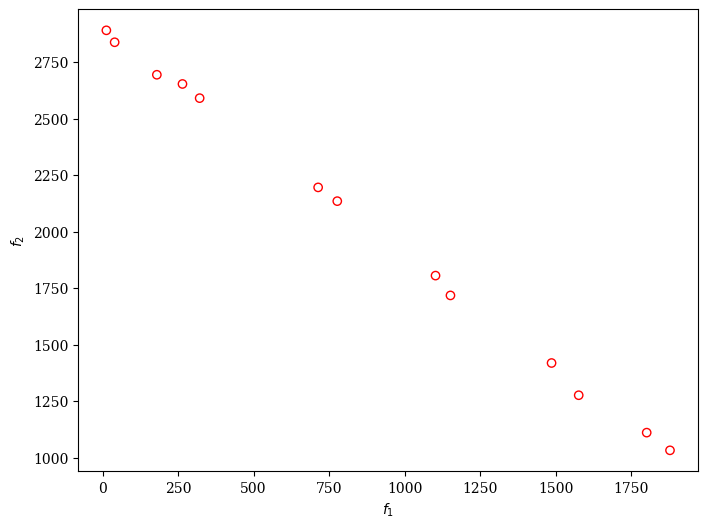

In [42]:
sc = Scatter(legend=False, angle=(45, 30))
sc.add(problem.pareto_front(ref_dirs), plot_type='surface', alpha=0.2, label="PF", color="blue")
sc.add(-res.F, facecolor="none", edgecolor="red")
sc.show()